### Main information of challenge
#### Overview
More detailed information can be found on the competition Kaggle site: https://www.kaggle.com/c/detroit-blight-ticket-compliance/overview

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Every year, Detroit issues millions of dollars in fines to residents that fail to maintain their property (called [blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs)), and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. In the prediction competition, your task is simple - predict whether a given blight ticket will be paid on time. We anticipate that the insights that you will gain during the course of this competition will be incredibly valuable to the people tirelessly working to end blight in Detroit. For this reason, we are adding a second competition track that allows you to share these insights directly with Detroit's blight team.

#### Data description
We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and include information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

#### Evaluation
Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this competition is the Area Under the Receiver Operating Characteristic (AUROC). The True Positive Rate (TPR) and False Positive Rate (FPR) of your predictions will be determined by the classification performance when the probability is thresholded at different values. The threshold is varied from 0 to 1, forming the ROC (tpr vs. fpr) curve. The area under the resulting ROC curve is the AUROC. See the Wikipedia article on AUROC for more details.

### This solution
Best result achieved was an AUC of 0.769 on the test set using a gradient-boosted decision trees method with five features.

### Load data (step 1)

In [210]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import time

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

train_load = pd.read_csv('train.csv', engine='python')
test_load = pd.read_csv('test.csv')

### Feature selection and data preprocessing (step 2)
Final features chosen from train and test sets: *agency_name*, *violation_code*, *disposition*, *late_fee*, *discount_amount* and *compliance* (target value). Other features were omitted due to various reasons, for example that they were deemed not to add any additional information, that they would have been interesting but contained almost only NaN values or that they would have contributed to data leakage and overfitting as they contained information about the future.

**Let's have a look at the data**

In [211]:
train_load.info();
#test_load.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

**We can already now drop some columns**

In [212]:
# Drop columns not present in test set (except target variable compliance)
train_load.drop(['payment_amount', 'payment_date', 'payment_status', 'balance_due',
                 'collection_status', 'compliance_detail'],
                 axis=1, inplace=True)

# Drop three columns containing less than 5 non-null entries
train_load.drop(['violation_zip_code', 'non_us_str_code', 'grafitti_status'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['violation_zip_code', 'non_us_str_code', 'grafitti_status'], axis=1, inplace=True)

# Set index in training column to ticket_id
train_load.set_index('ticket_id', inplace=True)

# Replicate for test set
test_load.set_index('ticket_id', inplace=True)

**Check our target variable**

In [213]:
train_load['compliance'].value_counts(dropna=False)

0.0    148283
NaN     90426
1.0     11597
Name: compliance, dtype: int64

In [214]:
# Drop rows from training data where compliance (i.e. target value) value is not 0 or 1
train_load = train_load[(train_load['compliance'] == 0.0) | (train_load['compliance'] == 1.0)]
train_load['compliance'] = train_load['compliance'].astype(int)

**Check overview statistics of numerical variables**

In [215]:
train_load.describe().T

,count,mean,std,min,25%,50%,75%,max
violation_street_number,159880.0,10713.155166,36231.585165,0.0,4920.0,10398.0,15783.25,14154108.0
mailing_address_str_number,157322.0,9133.713676,36577.294364,1.0,532.0,2418.0,12844.00,5111345.0
fine_amount,159880.0,357.035295,675.655580,0.0,200.0,250.0,250.00,10000.0
admin_fee,159880.0,20.000000,0.000000,20.0,20.0,20.0,20.00,20.0
state_fee,159880.0,10.000000,0.000000,10.0,10.0,10.0,10.00,10.0
late_fee,159880.0,33.651512,67.692916,0.0,10.0,25.0,25.00,1000.0
discount_amount,159880.0,0.195959,4.290344,0.0,0.0,0.0,0.00,350.0
clean_up_cost,159880.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
judgment_amount,159880.0,420.650218,742.555062,0.0,250.0,305.0,305.00,11030.0
compliance,159880.0,0.072536,0.259374,0.0,0.0,0.0,0.00,1.0


In [216]:
# A few of the columns looks suspicious
train_load['admin_fee'].value_counts(dropna=False) # contains only one unique value: 20
train_load['state_fee'].value_counts(dropna=False) # contains only one unique value: 10
train_load['clean_up_cost'].value_counts(dropna=False) # contains only one unique value: 0

0.0    159880
Name: clean_up_cost, dtype: int64

In [217]:
# Drop columns with only one unique value as they have no value for prediction
train_load.drop(['admin_fee'], axis=1, inplace=True)
train_load.drop(['state_fee'], axis=1, inplace=True)
train_load.drop(['clean_up_cost'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['admin_fee'], axis=1, inplace=True)
test_load.drop(['state_fee'], axis=1, inplace=True)
test_load.drop(['clean_up_cost'], axis=1, inplace=True)

**Check overview of all remaining features**

In [218]:
train_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 22056 to 284333
Data columns (total 21 columns):
agency_name                   159880 non-null object
inspector_name                159880 non-null object
violator_name                 159854 non-null object
violation_street_number       159880 non-null float64
violation_street_name         159880 non-null object
mailing_address_str_number    157322 non-null float64
mailing_address_str_name      159877 non-null object
city                          159880 non-null object
state                         159796 non-null object
zip_code                      159879 non-null object
country                       159880 non-null object
ticket_issued_date            159880 non-null object
hearing_date                  159653 non-null object
violation_code                159880 non-null object
violation_description         159880 non-null object
disposition                   159880 non-null object
fine_amount                   15988

In [219]:
# Drop columns where detailed info is available in other columns (zip_code and violation_code)
train_load.drop(['city', 'state', 'country', 'violation_description',], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['city', 'state', 'country', 'violation_description',], axis=1, inplace=True)

# Drop street number since intuition indicates it should be uninteresting for model
train_load.drop(['violation_street_number', 'mailing_address_str_number'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['violation_street_number', 'mailing_address_str_number'], axis=1, inplace=True)

**Perform chi2 test for categorical features**

In [220]:
train_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 22056 to 284333
Data columns (total 15 columns):
agency_name                 159880 non-null object
inspector_name              159880 non-null object
violator_name               159854 non-null object
violation_street_name       159880 non-null object
mailing_address_str_name    159877 non-null object
zip_code                    159879 non-null object
ticket_issued_date          159880 non-null object
hearing_date                159653 non-null object
violation_code              159880 non-null object
disposition                 159880 non-null object
fine_amount                 159880 non-null float64
late_fee                    159880 non-null float64
discount_amount             159880 non-null float64
judgment_amount             159880 non-null float64
compliance                  159880 non-null int32
dtypes: float64(4), int32(1), object(10)
memory usage: 18.9+ MB


In [221]:
le = LabelEncoder()
categorical = ['agency_name', 'inspector_name', 'violator_name', 'violation_street_name',
               'mailing_address_str_name', 'zip_code', 'ticket_issued_date', 'hearing_date',
               'violation_code', 'disposition', 'compliance']
train_cat = train_load[categorical]
train_cat = train_cat.apply(lambda col: le.fit_transform(col.astype(str)), axis=0)

<IPython.core.display.Javascript object>


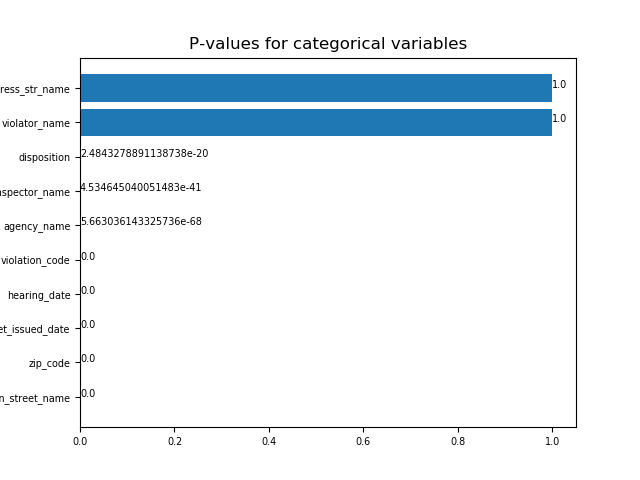

In [222]:
# Hypothesis: features are independent of the target variable
x_chi = train_cat.drop('compliance', axis=1)
y_chi = train_cat['compliance']

chi_scores = chi2(x_chi, y_chi)

p_values = pd.Series(chi_scores[1], index=x_chi.columns)
p_values.sort_values(ascending=True, inplace=True)

# Plot results (high p-value indicates the feature is independent of the target variable)
plt.figure()
plt.barh(p_values.index, p_values)
plt.title('P-values for categorical variables')
plt.yticks(fontsize='x-small')
plt.xticks(fontsize='x-small')
for index, value in enumerate(p_values):
    plt.text(value, index, value, fontsize='x-small')
plt.show();

In [223]:
# Drop columns based on chi square test results
train_load.drop(['mailing_address_str_name', 'violator_name'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['mailing_address_str_name', 'violator_name'], axis=1, inplace=True)

**Check correlation matrix for numerical features**

<IPython.core.display.Javascript object>


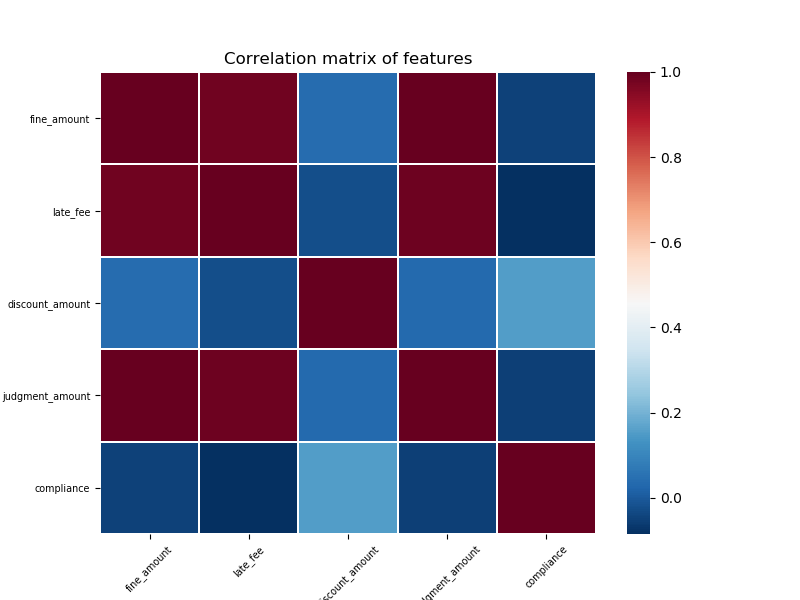

In [224]:
corr = train_load.corr(method='pearson')
plt.figure(figsize=(8,6))
ax = sns.heatmap(corr, cmap='RdBu_r', linewidth=0.8)
ax.set_title('Correlation matrix of features', fontsize='large')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize='x-small');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-small');

In [225]:
# Drop columns with a high correlation
train_load.drop(['fine_amount', 'judgment_amount'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['fine_amount', 'judgment_amount'], axis=1, inplace=True)

**Check the number of unique entries in each remaining column**

In [226]:
# Check number of unique entries in columns
train_load.apply(lambda col: col.nunique())

agency_name                  5
inspector_name             159
violation_street_name     1716
zip_code                  3498
ticket_issued_date       68097
hearing_date              5970
violation_code             189
disposition                  4
late_fee                    37
discount_amount             13
compliance                   2
dtype: int64

In [227]:
# Drop columns with a large number of unique values to enhance computational performance
train_load.drop(['ticket_issued_date', 'hearing_date', 'zip_code',
                 'violation_street_name'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['ticket_issued_date', 'hearing_date', 'zip_code',
                 'violation_street_name'], axis=1, inplace=True)

In [228]:
train_load.columns

Index(['agency_name', 'inspector_name', 'violation_code', 'disposition',
       'late_fee', 'discount_amount', 'compliance'],
      dtype='object')

**Transform categorical features to numerical**

In [229]:
# Create numerical columns of unique categorical data with NaN replaced by <unknown>
ucats_agency = set(train_load['agency_name'])|{'<unknown>'}
train_load['agency_name'] = pd.Categorical(train_load['agency_name'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(train_load['inspector_name'])|{'<unknown>'}
train_load['inspector_name'] = pd.Categorical(train_load['inspector_name'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(train_load['violation_code'])|{'<unknown>'}
train_load['violation_code'] = pd.Categorical(train_load['violation_code'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(train_load['disposition'])|{'<unknown>'}
train_load['disposition'] = pd.Categorical(train_load['disposition'],categories=ucats_agency).fillna('<unknown>').codes

# Replicate for test set
ucats_agency = set(test_load['agency_name'])|{'<unknown>'}
test_load['agency_name'] = pd.Categorical(test_load['agency_name'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(test_load['inspector_name'])|{'<unknown>'}
test_load['inspector_name'] = pd.Categorical(test_load['inspector_name'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(test_load['violation_code'])|{'<unknown>'}
test_load['violation_code'] = pd.Categorical(test_load['violation_code'],categories=ucats_agency).fillna('<unknown>').codes
ucats_agency = set(test_load['disposition'])|{'<unknown>'}
test_load['disposition'] = pd.Categorical(test_load['disposition'],categories=ucats_agency).fillna('<unknown>').codes

**Visualize features**

<IPython.core.display.Javascript object>


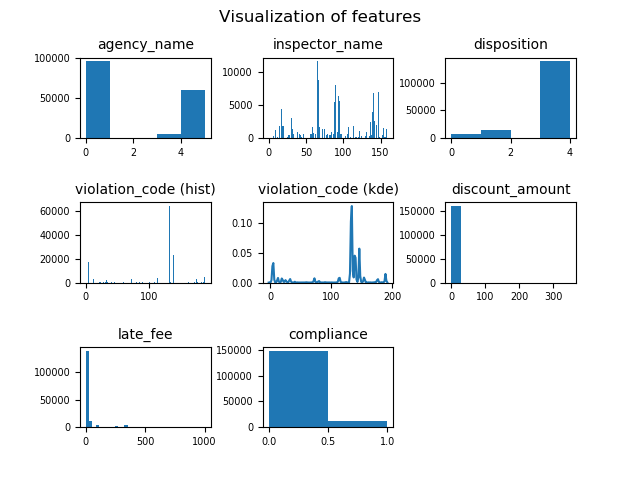

In [243]:
fig = plt.figure()
gspec = gridspec.GridSpec(3, 3, hspace=0.8, wspace=0.4)
fig.suptitle('Visualization of features')

ax1 = fig.add_subplot(gspec[0, 0])
ax1.hist(train_load['agency_name'], bins=train_load['agency_name'].nunique())
ax1.set_title('agency_name', fontsize='medium')
ax1.tick_params(axis='both', labelsize='x-small')

ax2 = fig.add_subplot(gspec[0, 1])
ax2.hist(train_load['inspector_name'], bins=train_load['inspector_name'].nunique())
ax2.set_title('inspector_name', fontsize='medium')
ax2.tick_params(axis='both', labelsize='x-small')

ax3 = fig.add_subplot(gspec[0, 2])
ax3.hist(train_load['disposition'], bins=train_load['disposition'].nunique())
ax3.set_title('disposition', fontsize='medium')
ax3.tick_params(axis='both', labelsize='x-small')

ax4 = fig.add_subplot(gspec[1, 0])
ax4.hist(train_load['violation_code'], bins=train_load['violation_code'].nunique())
ax4.set_title('violation_code (hist)', fontsize='medium')
ax4.tick_params(axis='both', labelsize='x-small')

ax5 = fig.add_subplot(gspec[1, 1])
ax5 = sns.kdeplot(train_load['violation_code'], legend=False, bw=1)
ax5.set_title('violation_code (kde)', fontsize='medium')
ax5.tick_params(axis='both', labelsize='x-small')

ax6 = fig.add_subplot(gspec[1, 2])
ax6.hist(train_load['discount_amount'], bins=train_load['discount_amount'].nunique())
ax6.set_title('discount_amount', fontsize='medium')
ax6.tick_params(axis='both', labelsize='x-small')

ax7 = fig.add_subplot(gspec[2, 0])
ax7.hist(train_load['late_fee'], bins=train_load['late_fee'].nunique())
ax7.set_title('late_fee', fontsize='medium')
ax7.tick_params(axis='both', labelsize='x-small')

ax8 = fig.add_subplot(gspec[2, 1])
ax8.hist(train_load['compliance'], bins=train_load['compliance'].nunique())
ax8.set_title('compliance', fontsize='medium')
ax8.tick_params(axis='both', labelsize='x-small')

**Reduce the long tail of values with low occurences in _violation_code_**

In [193]:
train_load.apply(lambda col: col.nunique())

agency_name          5
inspector_name     159
violation_code     189
disposition          4
late_fee            37
discount_amount     13
compliance           2
dtype: int64

In [194]:
# Set thresholds at the 0.2 and 0.8 quantiles
upper_lim = train_load['violation_code'].quantile(.80)
lower_lim = train_load['violation_code'].quantile(.20)
train_load = train_load[(train_load['violation_code'] < upper_lim) & (train_load['violation_code'] > lower_lim)]

In [195]:
train_load.apply(lambda col: col.nunique())

agency_name          5
inspector_name     142
violation_code      66
disposition          4
late_fee            20
discount_amount      8
compliance           2
dtype: int64

In [196]:
# Finally dropping inspector name to enhance computational performance
train_load.drop(['inspector_name'], axis=1, inplace=True)

# Replicate for test set
test_load.drop(['inspector_name'], axis=1, inplace=True)

In [197]:
train_load.columns, test_load.columns

(Index(['agency_name', 'violation_code', 'disposition', 'late_fee',
        'discount_amount', 'compliance'],
       dtype='object'),
 Index(['agency_name', 'violation_code', 'disposition', 'late_fee',
        'discount_amount'],
       dtype='object'))

**Split train and test data**

In [198]:
# Build feature and label space
trainX = train_load.drop('compliance', axis=1)
trainY = train_load['compliance']

In [244]:
# Create training and test sets for models (random_state for reproducible results)
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, random_state=0)

### Train and evaluate models (step 3)

#### Dummy classifier
Start by creating a dummy classifier always predicting the most frequent target value (i.e. 0).

Dummy classifier AUC score on test set:  0.5
Computation time:  0.029924631118774414  seconds


<IPython.core.display.Javascript object>


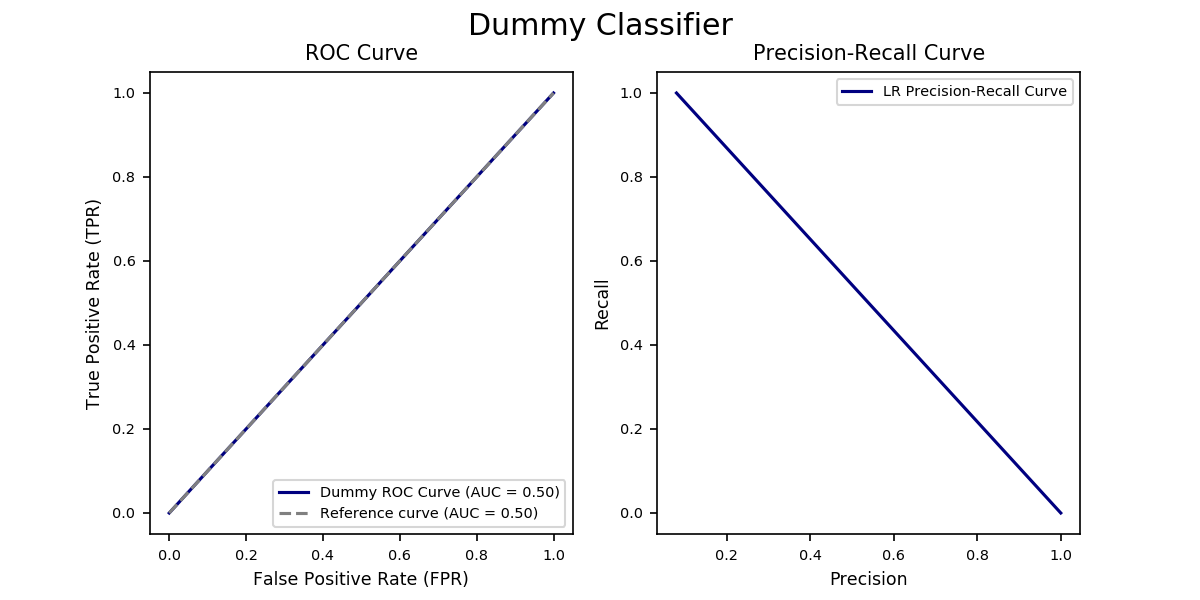

284932    0.0
285362    0.0
285361    0.0
285338    0.0
285346    0.0
dtype: float64

In [200]:
def dummy_test():
    start = time.time()
    clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
    y_score_dummy = clf_dummy.predict_proba(X_test)[:,1]
    roc_auc_score_dummy = roc_auc_score(y_test, y_score_dummy)
    precision_dummy, recall_dummy, thresholds_dummy = precision_recall_curve(y_test, y_score_dummy)
    fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_score_dummy)
    end = time.time()
    print('Dummy classifier AUC score on test set: ', roc_auc_score_dummy)
    print('Computation time: ', end-start, ' seconds')
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Dummy Classifier', fontsize='x-large')
    
    axes[0].plot(fpr_dummy, tpr_dummy, label='Dummy ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_dummy), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_dummy, recall_dummy, label='LR Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve', fontsize='medium')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(clf_dummy.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    
    return answer
    
dummy_test().head()

#### Logistic Regression (LR)
As we have a binary classification problem the model assumes the two labels to be 0 and 1.

C:\Users\sixte\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sixte\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sixte\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sixte\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sixte\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Logistic Regression AUC score on test set:  0.7625110331334424
Logistic Regression grid best parameter:  {'C': 0.01, 'penalty': 'l2'}
Logistic Regression grid best score (roc_auc):  0.7682135236628007
Computation time:  20.992568254470825  seconds


<IPython.core.display.Javascript object>


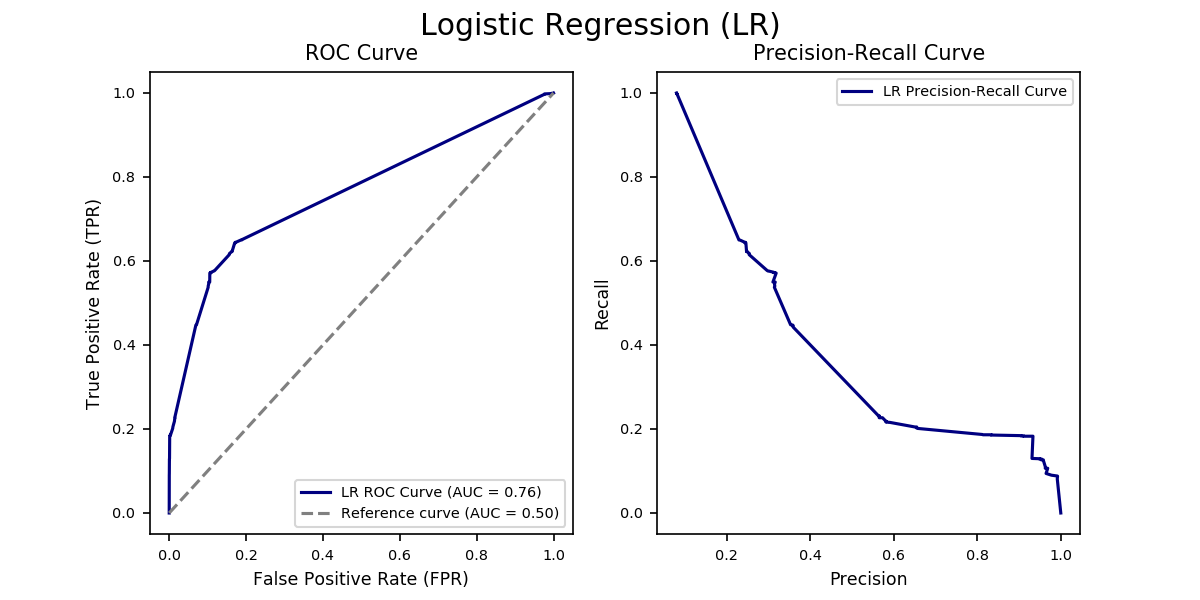

284932    0.054554
285362    0.001261
285361    0.092502
285338    0.050167
285346    0.078283
dtype: float64

In [201]:
def lr_test():
    start = time.time()
    clf_lr = LogisticRegression(solver='liblinear') # solver specified as lbfgs does not accept Lasso regularization (L1)
    grid_values_lr = {'penalty': ['l1', 'l2'],
                      'C': [0.01, 0.1, 1, 10, 100]}
    grid_clf_lr_auc = GridSearchCV(clf_lr, param_grid=grid_values_lr, scoring='roc_auc')
    grid_clf_lr_auc.fit(X_train, y_train)
    y_score_lr = grid_clf_lr_auc.decision_function(X_test)
    roc_auc_score_lr = roc_auc_score(y_test, y_score_lr)
    precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_score_lr)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
    end = time.time()
    print('Logistic Regression AUC score on test set: ', roc_auc_score_lr)
    print('Logistic Regression grid best parameter: ', grid_clf_lr_auc.best_params_)
    print('Logistic Regression grid best score (roc_auc): ', grid_clf_lr_auc.best_score_)
    print('Computation time: ', end-start, ' seconds')
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Logistic Regression (LR)', fontsize='x-large')
    
    axes[0].plot(fpr_lr, tpr_lr, label='LR ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_lr), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_lr, recall_lr, label='LR Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve', fontsize='medium')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(grid_clf_lr_auc.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    return answer
    
lr_test().head()

# Best result:
# Logistic Regression AUC score on test set:  0.7625110331334424
# Logistic Regression grid best parameter:  {'C': 0.01, 'penalty': 'l2'}
# Logistic Regression grid best score (roc_auc):  0.7682135236628007
# Computation time:  8.007613897323608  seconds

#### Support Vector Machine (SVM)
Radial basis function chosen as kernel as it is more likely the features are not separable by a linear model. The model is computationally heavy which is why only a few values for *gamma* and *C* are chosen in gridsearch.

SVM AUC score on test set:  0.7314862084303126
SVM grid best parameter:  {'C': 1, 'gamma': 'auto'}
SVM grid best score (roc_auc):  0.7039837445879963
Computation time:  572.7589862346649  seconds
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16858
           1       0.94      0.21      0.34      1455

    accuracy                           0.94     18313
   macro avg       0.94      0.60      0.65     18313
weighted avg       0.94      0.94      0.92     18313



<IPython.core.display.Javascript object>


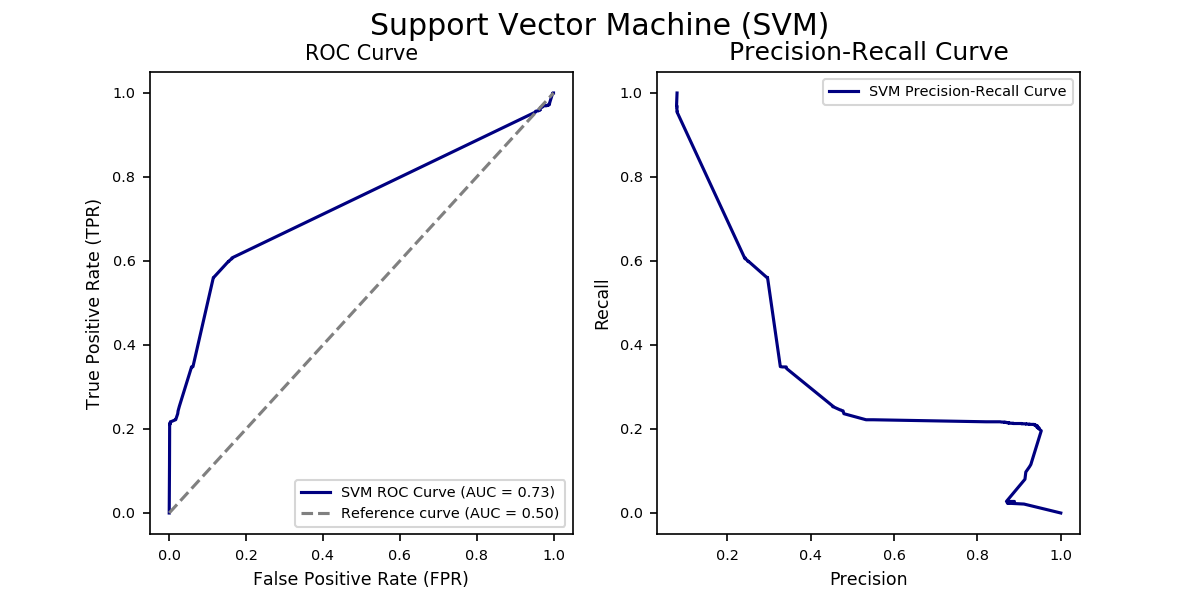

284932    0.125578
285362    0.125583
285361    0.125583
285338    0.110040
285346    0.089896
dtype: float64

In [202]:
def svm_test():
    start = time.time()
    clf_svm = SVC(kernel='rbf', probability=True)
    grid_values_svm = {'gamma': ['auto'],
                       'C': [1, 10]}
    grid_clf_svm_auc = GridSearchCV(clf_svm, param_grid = grid_values_svm, scoring='roc_auc')
    grid_clf_svm_auc.fit(X_train, y_train)
    y_score_svm = grid_clf_svm_auc.decision_function(X_test)
    roc_auc_score_svm = roc_auc_score(y_test, y_score_svm)
    precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_score_svm)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    end = time.time()
    print('SVM AUC score on test set: ', roc_auc_score_svm)
    print('SVM grid best parameter: ', grid_clf_svm_auc.best_params_)
    print('SVM grid best score (roc_auc): ', grid_clf_svm_auc.best_score_)
    print('Computation time: ', end-start, ' seconds')
    print(classification_report(y_test, grid_clf_svm_auc.predict(X_test)))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Support Vector Machine (SVM)', fontsize='x-large')
    
    axes[0].plot(fpr_svm, tpr_svm, label='SVM ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_svm), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_svm, recall_svm, label='SVM Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(grid_clf_svm_auc.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    return answer
    
svm_test().head()

# Best result:
# SVM AUC score on test set:  0.7314862084303126
# SVM grid best parameter:  {'C': 1, 'gamma': 'auto'}
# SVM grid best score (roc_auc):  0.7039837445879963

#### Gaussian Naive Bayes (GNB)
As there are no hyperparameters to optimize for Gaussian NB, no gridsearch is performed. The model assumes the features are independent.

GNB AUC score on test set:  0.754622704547669
Computation time:  0.038895368576049805  seconds


<IPython.core.display.Javascript object>


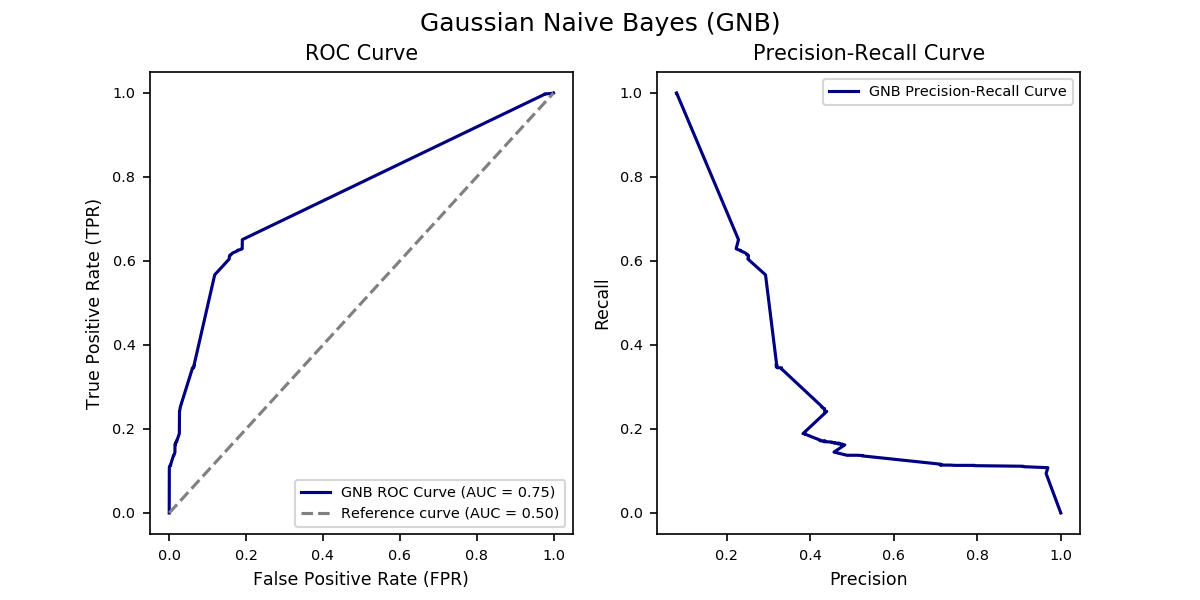

284932    9.949754e-01
285362    2.967691e-09
285361    1.000000e+00
285338    4.696752e-02
285346    1.053514e-01
dtype: float64

In [203]:
def gnb_test():
    start = time.time()
    clf_gnb = GaussianNB().fit(X_train, y_train)
    y_score_gnb = clf_gnb.predict_proba(X_test)[:,1]
    roc_auc_score_gnb = roc_auc_score(y_test, y_score_gnb)
    precision_gnb, recall_gnb, thresholds_gnb = precision_recall_curve(y_test, y_score_gnb)
    fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_score_gnb)
    end = time.time()
    print('GNB AUC score on test set: ', roc_auc_score_gnb)
    print('Computation time: ', end-start, ' seconds')
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Gaussian Naive Bayes (GNB)', fontsize='large')
    
    axes[0].plot(fpr_gnb, tpr_gnb, label='GNB ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_gnb), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_gnb, recall_gnb, label='GNB Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve', fontsize='medium')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(clf_gnb.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    return answer

gnb_test().head()

# Best result:
# GNB AUC score on test set:  0.754622704547669
# Computation time:  0.021976470947265625  seconds

#### Random Forest (RF)
Tuning is performed over *n_estimators* (numer of trees to use in ensemble), *max_depth* (depth of each tree) and *max_features* (diversity of tress in the forest). 

RF AUC score on test set:  0.7677836376541632
RF best parameter:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000}
RF best score:  0.7736465536297088
Computation time:  316.9829707145691  seconds
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16858
           1       0.94      0.21      0.34      1455

    accuracy                           0.94     18313
   macro avg       0.94      0.60      0.66     18313
weighted avg       0.94      0.94      0.92     18313



<IPython.core.display.Javascript object>


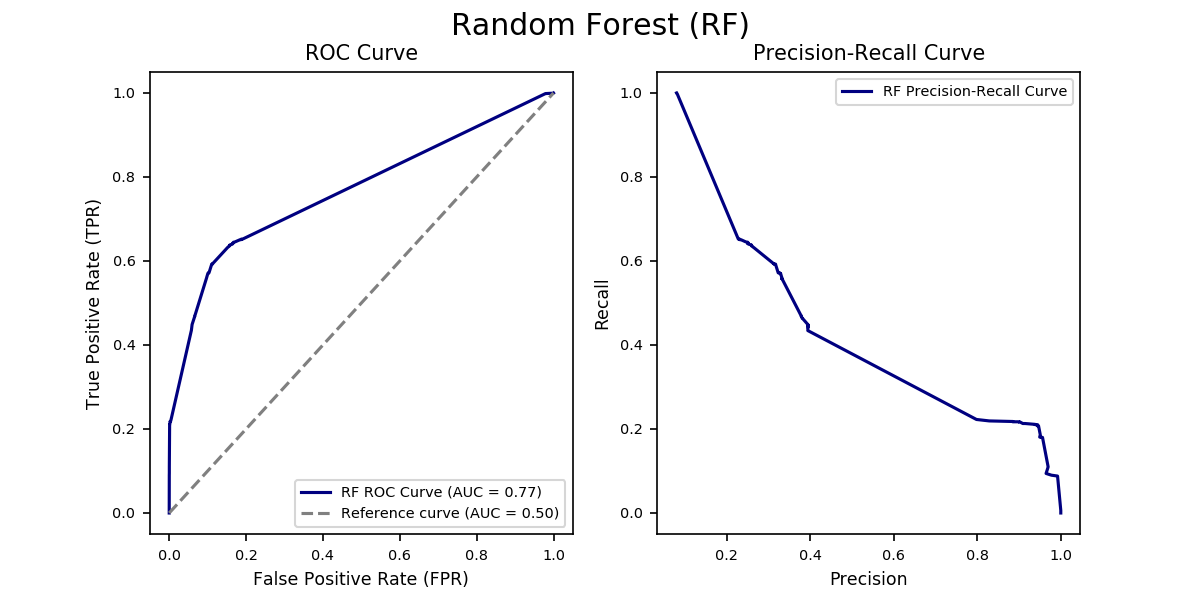

284932    0.073676
285362    0.020844
285361    0.077432
285338    0.039869
285346    0.045950
dtype: float64

In [204]:
def rf_test():
    start = time.time()
    clf_rf = RandomForestClassifier()
    grid_values_rf = {'n_estimators': [10, 100, 1000],
                      'max_depth': [5, 10],
                      'max_features': ['sqrt', 'log2', None]}
    grid_clf_rf_auc = GridSearchCV(clf_rf, param_grid=grid_values_rf, scoring='roc_auc')
    grid_clf_rf_auc.fit(X_train, y_train)
    y_score_rf = grid_clf_rf_auc.predict_proba(X_test)[:,1]
    roc_auc_score_rf = roc_auc_score(y_test, y_score_rf)
    precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
    end = time.time()
    print('RF AUC score on test set: ', roc_auc_score_rf)
    print('RF best parameter: ', grid_clf_rf_auc.best_params_)
    print('RF best score: ', grid_clf_rf_auc.best_score_)
    print('Computation time: ', end-start, ' seconds')
    print(classification_report(y_test, grid_clf_rf_auc.predict(X_test)))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Random Forest (RF)', fontsize='x-large')
    
    axes[0].plot(fpr_rf, tpr_rf, label='RF ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_rf), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_rf, recall_rf, label='RF Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve', fontsize='medium')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(grid_clf_rf_auc.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    return answer

rf_test().head()

# Best result:
# RF AUC score on test set:  0.7689788445144583
# RF best parameter:  {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
# RF best score:  0.773878403484266
# Computation time:  312.6471948623657  seconds

#### Gradient-Boosted Decision Trees (GBDT)
Tuning is performed over *learning_rate* (complexity of each tree), *n_estimators* (number of weak learners to use) and *max_depth* (size of each tree).

GBDT AUC score on test set:  0.7690617892164955
GBDT best parameter:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 600}
GBDT best score (roc_auc):  0.7734415420469636
Computation time:  1074.926573753357  seconds
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16858
           1       0.94      0.21      0.34      1455

    accuracy                           0.94     18313
   macro avg       0.94      0.60      0.66     18313
weighted avg       0.94      0.94      0.92     18313



<IPython.core.display.Javascript object>


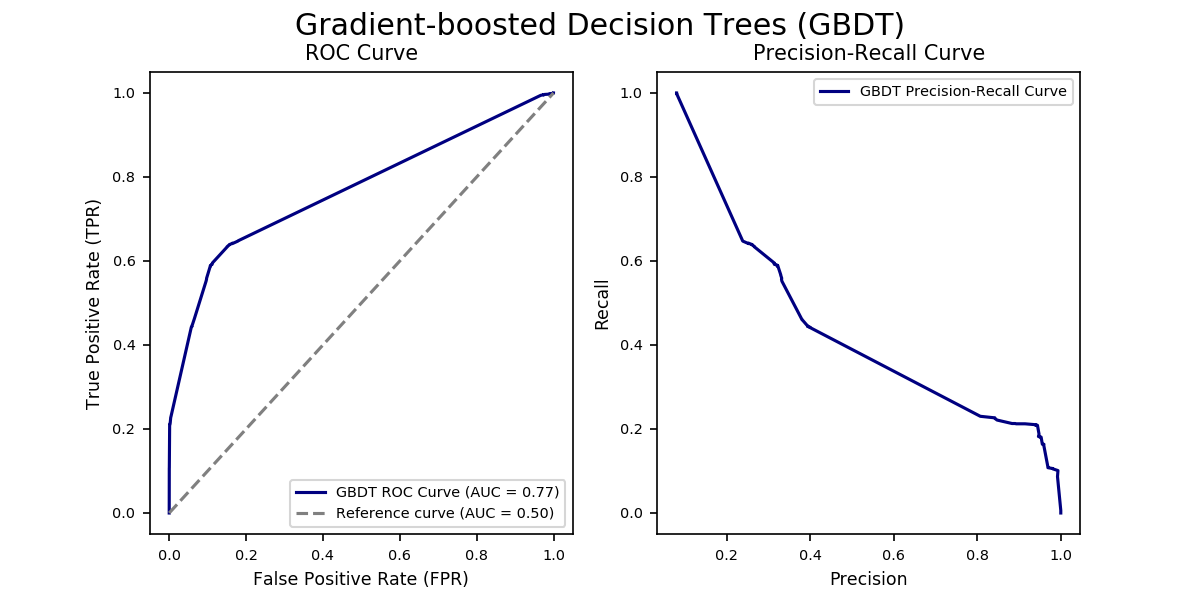

284932    0.020596
285362    0.002670
285361    0.016859
285338    0.020478
285346    0.080027
dtype: float64

In [207]:
def gbdt_test():
    start = time.time()
    clf_gbdt = GradientBoostingClassifier()
    grid_values_gbdt = {'learning_rate': [0.05, 0.1, 1],
                        'n_estimators': [100, 200, 400, 600, 1000],
                        'max_depth': [2, 3, 5]}
    grid_clf_gbdt_auc = GridSearchCV(clf_gbdt, param_grid=grid_values_gbdt, scoring='roc_auc')
    grid_clf_gbdt_auc.fit(X_train, y_train)
    y_score_gbdt = grid_clf_gbdt_auc.decision_function(X_test)
    roc_auc_score_gbdt = roc_auc_score(y_test, y_score_gbdt)
    precision_gbdt, recall_gbdt, thresholds_gbdt = precision_recall_curve(y_test, y_score_gbdt)
    fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_score_gbdt)
    end = time.time()
    print('GBDT AUC score on test set: ', roc_auc_score_gbdt)
    print('GBDT best parameter: ', grid_clf_gbdt_auc.best_params_)
    print('GBDT best score (roc_auc): ', grid_clf_gbdt_auc.best_score_)
    print('Computation time: ', end-start, ' seconds')
    print(classification_report(y_test, grid_clf_gbdt_auc.predict(X_test)))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    plt.suptitle('Gradient-boosted Decision Trees (GBDT)', fontsize='x-large')
    
    axes[0].plot(fpr_gbdt, tpr_gbdt, label='GBDT ROC Curve (AUC = {:0.2f})'.format(roc_auc_score_gbdt), color='navy')
    axes[0].plot([0,1], [0,1], label='Reference curve (AUC = 0.50)', linestyle='--', color='gray')
    axes[0].set_title('ROC Curve', fontsize='medium')
    axes[0].set_xlabel('False Positive Rate (FPR)', fontsize='small')
    axes[0].set_ylabel('True Positive Rate (TPR)', fontsize='small')
    axes[0].tick_params(axis='both', labelsize='x-small')
    axes[0].legend(loc='lower right', fontsize='x-small')
    
    axes[1].plot(precision_gbdt, recall_gbdt, label='GBDT Precision-Recall Curve', color='navy')
    axes[1].set_title('Precision-Recall Curve', fontsize='medium')
    axes[1].set_xlabel('Precision', fontsize='small')
    axes[1].set_ylabel('Recall', fontsize='small')
    axes[1].tick_params(axis='both', labelsize='x-small')
    axes[1].legend(loc='upper right', fontsize='x-small')
    
    answer = pd.Series(grid_clf_gbdt_auc.predict_proba(test_load)[:,1], test_load.index.tolist())
    
    return answer
    
gbdt_test().head()

# Best result:
# GBDT AUC score on test set:  0.7690617892164955
# GBDT best parameter:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 600}
# GBDT best score (roc_auc):  0.7734415420469636
# Computation time:  1074.926573753357  seconds